import scipy
print(scipy.__version__)

In [ ]:
!pip install scipy==1.11.4

In [ ]:
import scipy
print(scipy.__version__)

1.11.4


In [ ]:
pip install scikit-plot


---

# Facial Feature Analysis for Age Group Classification Using UTKFace

## Introduction

- Recently, the field of facial recognition and analysis has gained significant attention, majory in applications related to age classification.
- This notebook presents a comprehensive investigation **"Facial Feature Analysis for Age Group Classification Using UTKFace: A Comparative Study of Classical Machine Learning Models and Pretrained Deep Learning Models."**
- The primary research question guiding this investigation is: **“How do classical machine learning models compare to pretrained deep learning models in classifying age groups based on facial features extracted from the UTKFace dataset?”**

- The goal of this project is to assess and compare the effectiveness of traditional machine learning techniques, such as Support Vector Machines (SVM), Random Forest, and Logistic Regression, against state-of-the-art pretrained deep learning models like VGG16 and ResNet50.
- Through the use of UTKFace dataset, which consists of over 20,000 facial images annotated with age, gender, and ethnicity, we aim to uncover insights into the performance dynamics between classical and modern approaches to age classification.

### Problem Statement

- Facial images contains a wealth of information that can be analyzed for various demographic attributes, with age being a crucial aspect. The challenge lies in accurately classifying these age groups, especially given the complexities introduced by diverse facial features across different ages. By comparing classical and pretrained models, this study seeks to determine if traditional techniques can match or approximate the performance of more advanced methods in this domain.

### Dataset Overview

The **UTKFace dataset** is a large-scale collection of facial images with a wide age span, ranging from 0 to 116 years. It features over 20,000 images, annotated with age, gender, and ethnicity, making it an ideal candidate for this comparative analysis. The images in the dataset exhibit significant variations in pose, expression, and lighting, thus providing a rich foundation for model training and evaluation. The data can be access through https://www.kaggle.com/datasets/jangedoo/utkface-new/data

### Methodology

1. **Data Preprocessing and Exploration**: The UTKFace dataset will be loaded, preprocessed, and split into training, validation, and test sets.
2. **Model Training**: Classical machine learning models will be trained on facial features extracted from the dataset, while pretrained deep learning models will be fine-tuned for the same task.
3. **Model Evaluation**: The performance of each model will be evaluated using metrics such as accuracy, F1-score, precision, recall, Kappa, and ROC AUC.
4. **Comparative Analysis**: Results will be compared to provide insights into the effectiveness of classical models relative to deep learning architectures.

### Expected Results

- For this study, the results will reveal critical insights regarding the strengths and weaknesses of classical machine learning models in the context of age group classification. The comparison is expected to highlight whether classical models can achieve comparable accuracy levels to their pretrained counterparts or if deep learning techniques prove superior in this specific application.



---


In [ ]:

# import libs

# plotting and image view
from tqdm import tqdm
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
from PIL import Image

# data manipulation
import pandas as pd
import numpy as np
import os, glob, sys, cv2, gc
import warnings




# cnn models modules learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D, Input, InputLayer
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model


# evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, cohen_kappa_score,
    confusion_matrix, f1_score, classification_report, roc_auc_score
)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder


sns.set(style='whitegrid', palette='pastel', context='notebook')
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# plot settings
plt.rcParams['font.weight'] = "bold"
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['font.size'] = 15


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/MyDrive/UTKFace"

In [ ]:
# check the data
len(os.listdir(f"{BASE_DIR}"))

1131

In [ ]:
# view sample images
os.listdir(BASE_DIR)[-4:]

['86_0_1_20170120230044602.jpg.chip.jpg',
 '40_0_3_20170117135638072.jpg.chip.jpg',
 '2_1_0_20170109194422798.jpg.chip.jpg',
 '38_0_3_20170119202601638.jpg.chip.jpg']

---

### Extracting Labels from Image Filenames in the UTKFace Dataset

In the UTKFace dataset, each face image filename contains the metadata that facilitates the classification tasks associated with age group analysis. The filenames follow a structured format that encodes specific attributes:

- **Age**: shows an integer ranging from 0 to 116, this value indicates the age of the individual in the image.

- **Gender**: The gender of the individual is encoded as a binary value, where `0` denotes male and `1` denotes female.

- **Race**: The race is represented as an integer from 0 to 4, with each number corresponding to a specific racial category. The categories are as follows:
  - `0`: White
  - `1`: Black
  - `2`: Asian
  - `3`: Indian
  - `4`: Others (includes individuals of mixed race or those who do not fit into the aforementioned categories, such as Hispanic, Latino, or Middle Eastern).

- **Date & Time**: The date and time are embedded in the filename in the format `yyyymmddHHMMSSFFF`, providing precise temporal information about when the image was collected.


**Example Filename**:  
Consider the filename `66_0_1_20170117195116702.jpg.chip.jpg`. The components can be parsed as follows:
- **Age**: 66
- **Gender**: 0 (male)
- **Race**: 1 (Black)
- **Date & Time**: 2017-01-17 19:51:16.702

---

In [ ]:
# a function to get the parameters from the images
def extract_image_info(path):
    path_str = str(path)
    # Split the path and extract components
    components = path_str.split("_")
    age = int(components[0])
    gender_code = int(components[1])
    race_code = int(components[2])

    # Map codes to gender and race
    gender = "male" if gender_code == 0 else "female"
    race_mapping = {0: "white", 1: "black", 2: "asian", 3: "indian"}
    race = race_mapping.get(race_code, "others")
    return age, gender, race


#test on a sample
extract_image_info("66_0_1_20170117195116702.jpg.chip.jpg")

(66, 'male', 'black')

In [ ]:
# now lets extract these information
def extract_image_data(image_paths):
    """Extracts age, gender, and race from image filenames and returns a DataFrame."""
    image_data = []

    for img_path in tqdm(image_paths, desc="Processing Images"):
        try:
            # get filename and relevant info
            filename = img_path.split("UTKFace/")[-1]
            age, gender, race = extract_image_info(filename)

            # Append the extracted data
            image_data.append([img_path, age, gender, race])
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # get as a df list to DataFrame
    return pd.DataFrame(image_data, columns=["Image_Path", "Age", "Gender", "Race"]).sample(frac=1, random_state=2024)


In [ ]:
# get the paths
image_paths = glob.glob(f"{BASE_DIR}/*.jpg")

# create a data for the paths
df = extract_image_data(image_paths)


Processing Images: 100%|██████████| 1181/1181 [00:00<00:00, 91394.18it/s]


In [ ]:
# check a sample of them
df.head(12)

,Image_Path,Age,Gender,Race
1125,/content/drive/MyDrive/UTKFace/27_1_0_20170103...,27,female,white
27,/content/drive/MyDrive/UTKFace/1_1_1_201701091...,1,female,black
1,/content/drive/MyDrive/UTKFace/26_1_0_20170117...,26,female,white
232,/content/drive/MyDrive/UTKFace/26_1_0_20170116...,26,female,white
665,/content/drive/MyDrive/UTKFace/46_0_3_20170119...,46,male,indian
428,/content/drive/MyDrive/UTKFace/31_0_1_20170113...,31,male,black
1037,/content/drive/MyDrive/UTKFace/16_0_4_20170102...,16,male,others
1043,/content/drive/MyDrive/UTKFace/16_1_3_20170109...,16,female,indian
141,/content/drive/MyDrive/UTKFace/24_1_2_20170116...,24,female,asian
188,/content/drive/MyDrive/UTKFace/25_1_1_20170117...,25,female,black


## Age Grouping Strategy for UTKFace Dataset

- As from the study, we will categorize the age data into distinct **age groups** to facilitate more meaningful insights into how well classical machine learning models and pretrained deep learning models classify facial features.
- The motive of the grouping ages in specific ranges is based on **human development stages** and their relevance to **facial feature changes** over time which is majory over all races.
- The following are the groups in which are going to be created based on the age column.

    1. **Children (1-14) – Class 0:**  
       This group represents is the first life of a person where the facial features are still developing.

    2. **Youth (14-25) – Class 1:**  
       Youth is characterized by the transition from adolescence to early adulthood. Facial features stabilize but continue to undergo subtle changes. The group might pose more challenges to the models as it is an overlap of both adolescence and young adulthood.

    3. **Adults (25-40) – Class 2:**  
       This range marks the peak of physical maturity, with facial features remaining relatively stable. Models might be very good at these stage since there is less variability of appearance within the range.

    4. **Middle Age (40-60) – Class 3:**  
       Middle age introduces visible signs of aging i.e the wrinkles and changes in skin texture start to develop. This group allows us to explore how well models can detect and classify these aging characteristics.

    5. **Very Old (>60) – Class 4:**  
       The final group includes individuals over 60, where aging becomes more prominent. The models must accurately classify features associated with advanced aging i.e sagging skin and deep wrinkles.


- The above selected age groups align with key **developmental phases** and **physical changes** that are likely to impact facial recognition.

In [ ]:
def create_age_group(age):
    """Categorize age into predefined age groups."""
    if 1 <= age < 14:
        return 'Children'
    elif 14 <= age < 25:
        return 'Youth'
    elif 25 <= age < 40:
        return 'Adults'
    elif 40 <= age < 60:
        return 'Middle Age'
    elif age >= 60:
        return 'Very Old'
    else:
        return 'Unknown'

# apply the function
df['Age_Group'] = df['Age'].apply(create_age_group)


In [ ]:
df.head()

,Image_Path,Age,Gender,Race,Age_Group
1125,/content/drive/MyDrive/UTKFace/27_1_0_20170103...,27,female,white,Adults
27,/content/drive/MyDrive/UTKFace/1_1_1_201701091...,1,female,black,Children
1,/content/drive/MyDrive/UTKFace/26_1_0_20170117...,26,female,white,Adults
232,/content/drive/MyDrive/UTKFace/26_1_0_20170116...,26,female,white,Adults
665,/content/drive/MyDrive/UTKFace/46_0_3_20170119...,46,male,indian,Middle Age


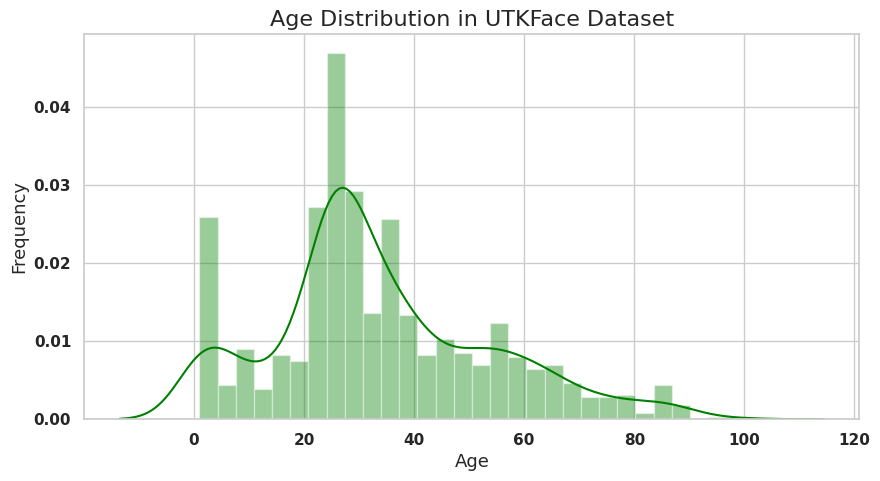

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot(df['Age'], bins=30, kde=True, color='green')
plt.title("Age Distribution in UTKFace Dataset")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

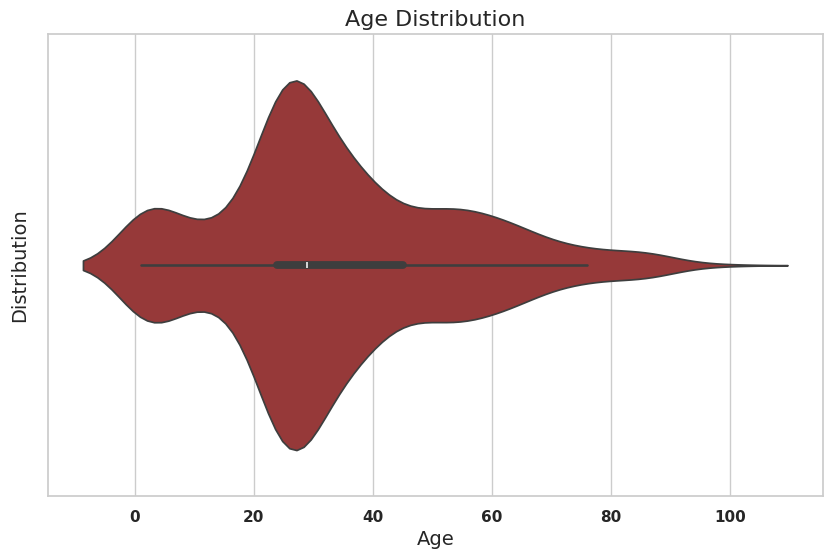

In [ ]:
# check with violin
plt.figure(figsize=(10, 6))
sns.violinplot(x=df['Age'], color='brown')
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Distribution', fontsize=14)
plt.show()

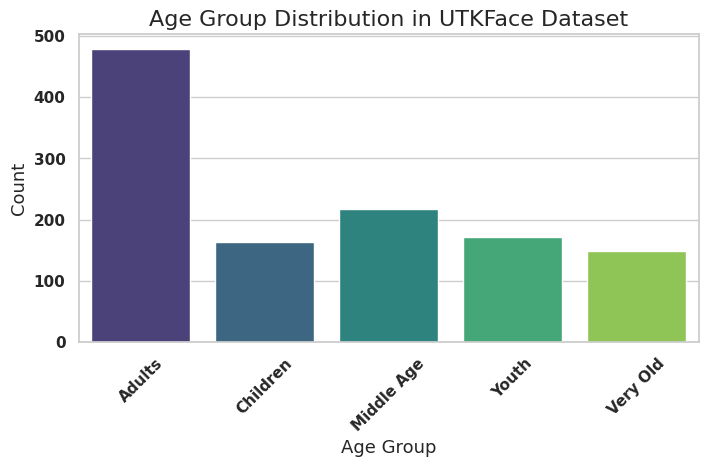

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Age_Group', palette='viridis')
plt.title("Age Group Distribution in UTKFace Dataset")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Text(0.5, 1.0, 'Analysis of Age vs Race accross different genders')

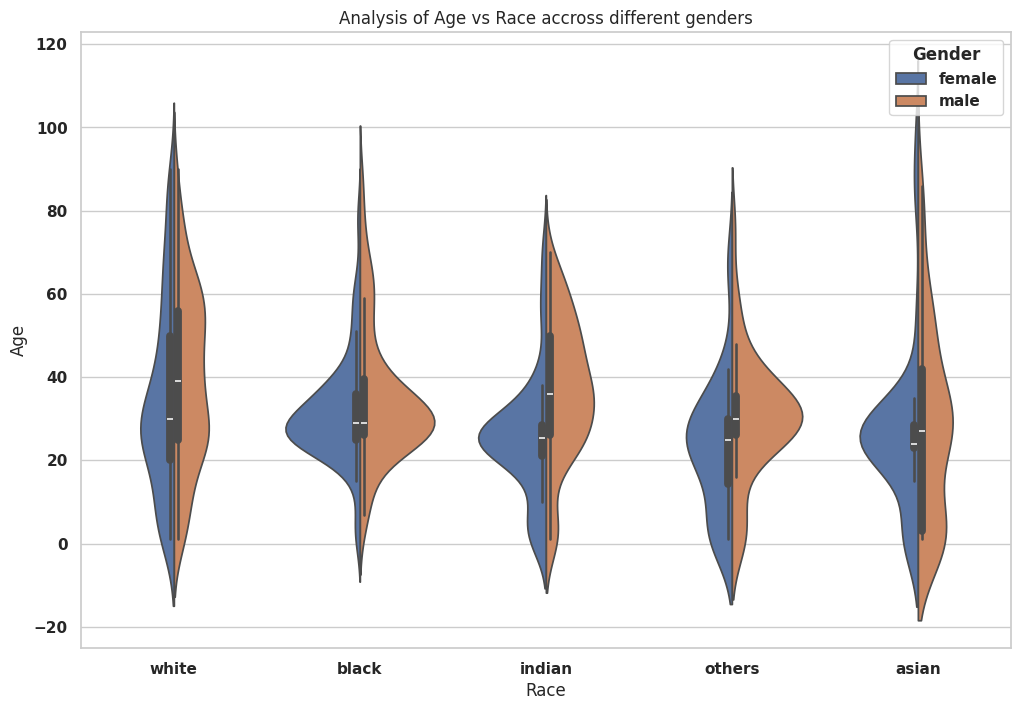

In [ ]:
# plot an analysis of gender vs, race and age
sns.set(style="whitegrid")
sns.violinplot(x='Race',y='Age',hue='Gender',split=True,data=df)
plt.title("Analysis of Age vs Race accross different genders")

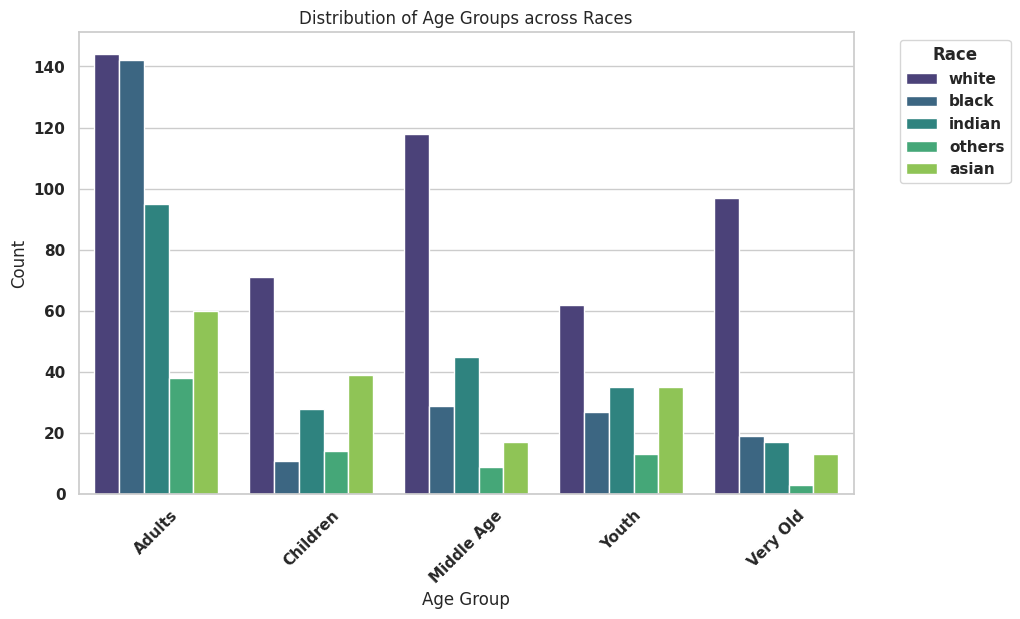

In [ ]:
# Age Group vs Race Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Age_Group', hue='Race', palette='viridis')
plt.title("Distribution of Age Groups across Races")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

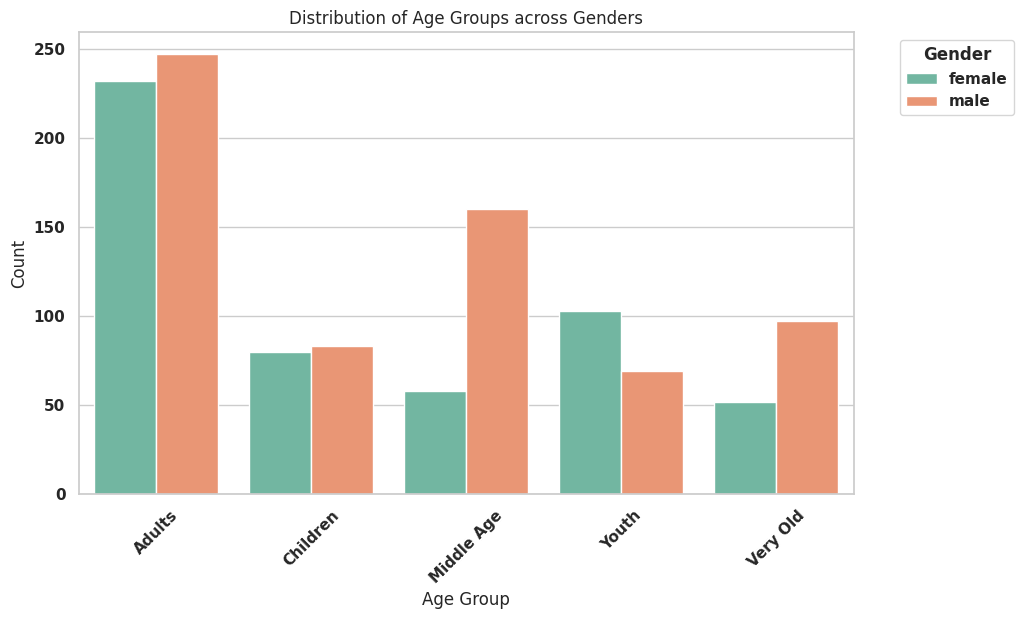

In [ ]:
# Age Group vs Gender Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Age_Group', hue='Gender', palette='Set2')
plt.title("Distribution of Age Groups across Genders")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


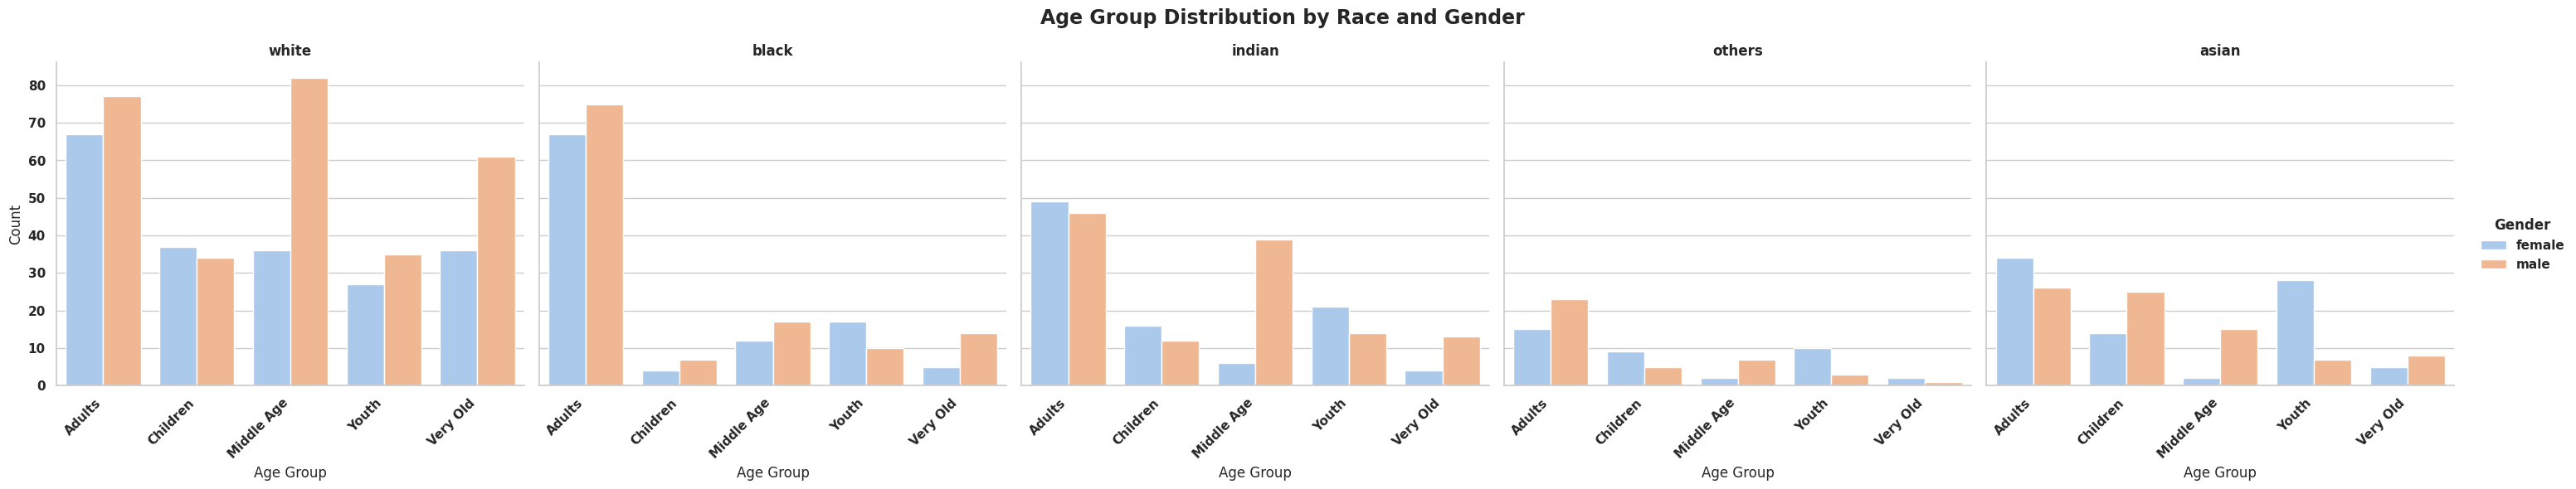

In [ ]:
# for Age Group vs Race and Gender
g = sns.catplot(
    data=df,
    x='Age_Group',
    hue='Gender',
    col='Race',
    kind='count',
    height=5,
    aspect=1.2,
    palette='pastel'
)

g.set_titles("{col_name}", fontweight='bold', fontsize=15)
g.set_axis_labels("Age Group", "Count")
g.fig.suptitle("Age Group Distribution by Race and Gender", y=1.05, fontweight='bold', fontsize=17)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')

plt.show()


In [ ]:
# get the labels as numerical
# get mapping for predefined age groups to numerical classes
age_group_mapping = {
        'Children': 0,  # 1-14 years
        'Youth': 1,     # 14-25 years
        'Adults': 2,    # 25-40 years
        'Middle Age': 3, # 40-60 years
        'Very Old': 4   # 60+ years
    }

# map the age group labels to their respective numerical values
df['label'] = df["Age_Group"].map(age_group_mapping).fillna(-1).astype(int)

df.head()

,Image_Path,Age,Gender,Race,Age_Group,label
1125,/content/drive/MyDrive/UTKFace/27_1_0_20170103...,27,female,white,Adults,2
27,/content/drive/MyDrive/UTKFace/1_1_1_201701091...,1,female,black,Children,0
1,/content/drive/MyDrive/UTKFace/26_1_0_20170117...,26,female,white,Adults,2
232,/content/drive/MyDrive/UTKFace/26_1_0_20170116...,26,female,white,Adults,2
665,/content/drive/MyDrive/UTKFace/46_0_3_20170119...,46,male,indian,Middle Age,3



### Data Splitting

For data splitting, we employ a **stratified 5-fold cross-validation strategy** to efficiently utilize the available data for model training and evaluation. This approach ensures that each fold maintains a balanced representation of the age groups.

The data is divided into 5 folds, where 2 folds serve as the **testing** set and **validation** (one each), while the remaining 3 folds are used for **training**.

This means our data will be split as follows:

- **Training**: 60%
- **Testing**: 20%
- **Validation**: 20%

This stratified splitting allows for a more representative assessment of the model's performance across different age groups, ensuring that the classification is robust and reliable.


In [ ]:

# functions to do spliting
def stratified_split(data, target_col, n_splits=5, seed=2024):
    """Perform stratified K-Fold splitting."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_idx, test_idx in skf.split(data, data[target_col]):
        train_data = data.iloc[train_idx].reset_index(drop=True)
        test_data = data.iloc[test_idx].reset_index(drop=True)
        return train_data, test_data

def split_train_validation(train_data, target_col, n_splits=4, seed=2023):
    """Further split training data into train and validation sets."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_idx, valid_idx in skf.split(train_data, train_data[target_col]):
        return (
            train_data.iloc[train_idx].reset_index(drop=True),
            train_data.iloc[valid_idx].reset_index(drop=True)
        )


In [ ]:
# Sample 10,000 images
sample_df = df.sample(frac=1, random_state=2024)

# we are classifying the 'Age_Group' column hence stratified splits it
train_data_dump, test_data = stratified_split(sample_df, 'Age_Group')

# split the training data into train and validation sets using 'Age_Group'
train_data, valid_data = split_train_validation(train_data_dump, 'Age_Group')



In [ ]:
# get the sizes
len(train_data)/sample_df.shape[0], len(valid_data)/sample_df.shape[0], len(test_data)/sample_df.shape[0]

(0.5994919559695173, 0.19983065198983913, 0.20067739204064353)

In [ ]:
train_data.head()

,Image_Path,Age,Gender,Race,Age_Group,label
0,/content/drive/MyDrive/UTKFace/1_0_2_201612191...,1,male,asian,Children,0
1,/content/drive/MyDrive/UTKFace/31_1_1_20170117...,31,female,black,Adults,2
2,/content/drive/MyDrive/UTKFace/100_1_2_2017010...,100,female,asian,Very Old,4
3,/content/drive/MyDrive/UTKFace/26_1_2_20170116...,26,female,asian,Adults,2
4,/content/drive/MyDrive/UTKFace/20_1_4_20161223...,20,female,others,Youth,1


In [ ]:
# function to load data
def load_training_data(data, img_size=(224, 224)):
    """
    Load images from file paths and return them along with their corresponding age group labels.
    """
    images = []
    labels = []

    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        img_path = row['Image_Path']
        img = cv2.imread(img_path)

        if img is not None:
            # Resize the image to the desired size
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(row['label'])
        else:
            print(f"Warning: Could not load image at {img_path}")

    # rescale pixel values to be between 0 and 1
    images = np.array(images).astype('float32') / 255.0
    labels = np.array(labels)

    return images, labels


In [ ]:
# get training data
Xtrain, Ytrain = load_training_data(train_data)

100%|██████████| 708/708 [00:47<00:00, 15.05it/s] 


In [ ]:
# test data
Xtest, Ytest = load_training_data(test_data)

100%|██████████| 237/237 [00:01<00:00, 139.23it/s]


In [ ]:
# get validation data
Xval, Yval = load_training_data(valid_data)

100%|██████████| 236/236 [00:01<00:00, 142.14it/s]


In [ ]:
# check their sizes
Xval.shape, Xtrain.shape, Xtest.shape, Yval.shape, Ytrain.shape, Ytest.shape

((236, 224, 224, 3),
 (708, 224, 224, 3),
 (237, 224, 224, 3),
 (236,),
 (708,),
 (237,))

In [ ]:
print("Continue")

Continue


### Transfer Learning with ResNet50 and VGG16
- Transfer learning involves reusing a pre-trained model, initially trained on a large dataset, for a different task. In image classification, models like ResNet50/VGG16 are commonly employed.
- The pre-trained ResNet50/VGG16 model serves as a feature extractor, leveraging its learned representations for a new task.
- For transfer learning, I modified the input and output layers of ResNet50/VGG16 to align with the specific requirements of our task. This process allows us to benefit from the knowledge captured by the model during its pre-training.
- I opted for the "Feature Extraction" method, where only the input and output layers are modified. The hidden layers, with their learned feature maps, remain unchanged. This approach is computationally efficient and well-suited for tasks where significant customization is unnecessary.
- Through adopting this transfer learning strategy, I aim to harness the power of ResNet50's/VGG16's pre-learned features to enhance the performance of our model on the AGE GROUP IDENTIFICATION FROM UTK FACE DATASET without the need to train a large model from scratch.

In [ ]:
# set training parameters
IMG_SHAPE = Xtrain.shape[1:]
NUM_CLASSES = df['label'].nunique()
NUM_EPOCHS = 10
BATCH_SIZE=64
IMG_SHAPE, NUM_CLASSES

((224, 224, 3), 5)

### VGG16 Model

In [ ]:
# clear session first
tf.keras.backend.clear_session()


# Maximum pooling reduces the dimensions by selecting the largest value in each feature map.
vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape =IMG_SHAPE)

#we will not train the first 15 layers to freeze the pre-trained part of the model and ensure that only newly added layers are trained.
for layer in vgg_base_model.layers[:15]:
    layer.trainable = False


vgg_base = vgg_base_model.output
vgg_base = GlobalAveragePooling2D()(vgg_base)
vgg_base = Dense(512, activation = 'relu')(vgg_base)
vgg_base = Dropout(0.2)(vgg_base)
vgg_base = Dense(256, activation = 'relu')(vgg_base)
vgg_base = Dense(128, activation = 'relu')(vgg_base)
vgg_base = Dense(32, activation = 'relu')(vgg_base)
vgg_out = Dense(NUM_CLASSES, activation = "softmax")(vgg_base)

# merge the base and output head
vgg_model = Model(inputs = vgg_base_model.input, outputs = vgg_out)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# check the model summary
vgg_model.summary()

In [ ]:
from tensorflow.keras import backend as K
# a function to get f1 score
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1



In [ ]:
# Compile the model
vgg_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1])


In [ ]:
# to save best model, lets have a checkpoint
vgg_checkpoint = ModelCheckpoint("utk_vgg16_model.h5", save_best_only=True)
vgg_callback = [EarlyStopping(patience=5, monitor='val_loss', verbose=1),vgg_checkpoint]

In [ ]:
# check layers to train
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

In [ ]:
to_categorical(Ytrain).shape

In [ ]:
# train the model
vgg_hist = vgg_model.fit(
    Xtrain, to_categorical(Ytrain),
    epochs=NUM_EPOCHS,
    validation_data=(Xval, to_categorical(Yval)),
    callbacks=vgg_callback,
    batch_size=BATCH_SIZE
)

In [ ]:
vgg_hist.history.keys()


In [ ]:
def plot_training_history(history, model_name):
    acc = history['acc']
    val_acc = history['val_acc']
    f1 = history['f1']
    val_f1 = history['val_f1']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 3, figsize=(18,7))

    axes[0].plot(epochs, acc, 'yo-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'go--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')
    axes[0].grid(False)

    axes[1].plot(epochs, f1, 'ro-', label='Training F1')
    axes[1].plot(epochs, val_f1, 'bo--', label='Validation F1')
    axes[1].set_title('Training and Validation F1 Scores')
    axes[1].legend(loc='best')
    axes[1].grid(False)


    axes[2].plot(epochs, loss, 'ko-', label='Training Loss')
    axes[2].plot(epochs, val_loss, 'co--', label='Validation Loss')
    axes[2].set_title('Training and Validation Loss')
    axes[2].legend(loc='best')
    axes[2].grid(False)

    plt.suptitle(f"Training and Validation Trends for {model_name}", fontsize=17, fontweight='bold')



    plt.show()


In [ ]:
plot_training_history(vgg_hist.history, "VGG16")

In [ ]:

# function to assess and visualize model performance
def evaluate_model_performance(y_true, y_pred, model_name):
    # show evaluation metrics
    print(f"\n****** Evaluation Summary for {model_name} *********\n")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall Score: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Precision Score: {precision_score(y_true, y_pred, average='weighted'):.4f}\n")

    #act labels
    class_labels =list(age_group_mapping.keys())

    # get confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Visualize the confusion matrix
    plt.figure(figsize=(7, 7))
    sns.heatmap(confusion_mat, annot=True, fmt='', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
    plt.xlabel('True Labels', fontsize=15, fontweight='bold')
    plt.ylabel('Predicted Labels', fontsize=16, fontweight='bold')
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()


# function to plot ROC AUC and Precision-Recall curves
def plot_performance_curves(y_test, y_test_probs, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot ROC AUC curve
    skplt.metrics.plot_roc_curve(y_test, y_test_probs, ax=axes[0])
    axes[0].set_title('ROC Curve')

    # Plot Precision-Recall curve
    skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs, ax=axes[1])
    axes[1].set_title('Precision-Recall Curve')

    plt.suptitle(f"Performance Curves for Gender Classification using {model_name}", fontweight='bold')
    plt.show()


In [ ]:
# load the best perfoming model
vgg_model.load_weights('utk_vgg16_model.h5')

In [ ]:
vgg_model.evaluate(Xtest, to_categorical(Ytest))

In [ ]:
# get  predictions on test
vgg_test_preds = vgg_model.predict(Xtest)

In [ ]:

evaluate_model_performance(Ytest, vgg_test_preds.argmax(axis=1), "VGG16 MODEL")

In [ ]:

plot_performance_curves(Ytest, vgg_test_preds, "VGG16 MODEL")

In [ ]:
INVERSE_MAPPINGS = {v:k for k,v in age_group_mapping.items()}

In [ ]:
def run_test_predictions(xtest=Xtest, ytest=Ytest, model=vgg_model, model_name="VGG16 MODEL", n=32, cnn=True):
    index=np.random.randint(low=0,high=2000,size=n)
    fig=plt.figure(figsize=(20,12))
    for i in range(n):
        if cnn:
            pred=model.predict(xtest[index[i]].reshape(1,IMG_SHAPE[0],IMG_SHAPE[1],IMG_SHAPE[2]), verbose=0)
        else:
            pred = model.predict_proba( xtest[index[i]].reshape(1, -1))
        pred=np.argmax(pred)
        actual=ytest[index[i]]
        fig.add_subplot(n//8,8,i+1)
        plt.xticks([])
        plt.yticks([])
        if actual==pred:
            plt.title(f"Pred: {INVERSE_MAPPINGS.get(pred)}\nAct:{(INVERSE_MAPPINGS.get(actual))}",color='green',fontsize=14,fontweight="bold")
        else:
            plt.title(f"Pred: {INVERSE_MAPPINGS.get(pred)}\nAct: {(INVERSE_MAPPINGS.get(actual))}",color='red',fontsize=14,fontweight="bold")
        plt.imshow(Xtest[index[i]],cmap='gray')
    plt.suptitle(f"SAMPLE PREDICTIONS FOR {model_name.upper()}", fontweight="bold", fontsize=15)

In [ ]:
# visualize samples
run_test_predictions(xtest=Xtest, ytest=Ytest, model=vgg_model, model_name="VGG16 MODEL", n=32)

### RESNET50 Model

In [ ]:
# get the ResNet50 architecture with pre-trained ImageNet weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# Freeze the layers up to the end of the second residual block (conv3_block4_out)
# for layer in base_model.layers:
#     if 'conv4_block1' in layer.name:  # unfree from this block onwards
#         break
#     layer.trainable = False

# add some custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
output = Dense(df["label"].nunique(), activation='softmax')(x)


# merge them for the final model
resnet_model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# check model shape
print(f"We have {len(resnet_model.layers)} Layes in the model")

In [ ]:
# compile the model
resnet_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])

In [ ]:
# to save best model, lets have a checkpoint
resnet_checkpoint = ModelCheckpoint("utk_resnet50_model.h5", save_best_only=True)
resnet_callback = [EarlyStopping(patience=5, monitor='val_loss', verbose=1),resnet_checkpoint]

In [ ]:
# train the resnet model
restnet_hist = resnet_model.fit(
    Xtrain, to_categorical(Ytrain),
    epochs=NUM_EPOCHS,
    validation_data=(Xval, to_categorical(Yval)),
    callbacks=resnet_callback,
    batch_size=BATCH_SIZE
)

In [ ]:
plot_training_history(restnet_hist.history, "RESNET50 MODEL")

In [ ]:
# load the model
resnet_model.load_weights("utk_resnet50_model.h5")

In [ ]:
resnet_model.evaluate(Xtest, to_categorical(Ytest))

In [ ]:
# get  predictions on test
resnet_test_preds = resnet_model.predict(Xtest)


In [ ]:
evaluate_model_performance(Ytest, resnet_test_preds.argmax(axis=1), "RESNET50 MODEL")


In [ ]:
plot_performance_curves(Ytest, resnet_test_preds, "RESNET50 MODEL")

In [ ]:
# visualize samples
run_test_predictions(xtest=Xtest, ytest=Ytest, model=resnet_model, model_name="RESNET50 MODEL", n=32)

### CLassical Machine Learning models
- The main goal of the project was to investigate how perfomance of classical models differs from pretrained models.
- A **pre-trained ResNet model** is used to extract flat features for classical machine learning models, followed by **PCA for dimensionality reduction**.
- This approach investigates the performance of **classical models (SVM, Random Forest, and Logistic Regression)** compared to deep learning models.

### Feature Extraction with VGG16 and Classical Models Training

1. **Feature Extraction with VGG16**:  
   - The **VGG16** model is loaded without its top (classification) layers using `include_top=False`.
   - This allows us to extract meaningful **feature maps** from the input images. The feature maps are **flattened** into 2D matrices.

2. **Dimensionality Reduction with PCA**:  
   - **PCA** helps in reducing the high-dimensional feature vectors extracted from VGG16 into a lower-dimensional space (100 features in this example).  
   - For **training**, the PCA model is fitted, while for testing, the same PCA transformation is applied to ensure consistency.

3. **Classical Machine Learning Models**:  
   - **SVM**: Works well for small datasets with high-dimensional input.  
   - **Random Forest**: A strong ensemble model that performs well across different feature sets.  
   - **Logistic Regression**: Serves as a baseline for performance comparison.



In [ ]:
from sklearn.decomposition import PCA
# we want to get 250 features after dimension reductions
REDUCED_FEATURES = 250

# Step 1: load the VGG16 model without the top classification layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
feature_extractor = Model(inputs=vgg_base.input, outputs=vgg_base.output)

# Step 2: a function to extracting features and applying PCA reduction
def extract_important_flat_features(extractor_model, dataset, components=REDUCED_FEATURES, fit_pca=True, pca_model=None):
    # get feature maps from the pretrained model
    raw_features = extractor_model.predict(dataset)
    flattened_features = raw_features.reshape(raw_features.shape[0], -1)

    if fit_pca:
        # fit and apply PCA for dimensionality reduction
        pca_model = PCA(n_components=components)
        transformed_features = pca_model.fit_transform(flattened_features)
    else:
        # use provided PCA model to transform the dataset
        if pca_model is None:
            raise ValueError("PCA model must be supplied for testing.")
        transformed_features = pca_model.transform(flattened_features)

    return transformed_features, pca_model


In [ ]:
# extract features from VGG16 and apply PCA
Xtrain_features, pca_ = extract_important_flat_features(feature_extractor, Xtrain, fit_pca=True)
Xtest_features, _ = extract_important_flat_features(feature_extractor, Xtest, fit_pca=False, pca_model=pca_)


In [ ]:
# check their shape
Xtrain_features.shape,Xtest_features.shape, Ytrain.shape, Ytest.shape

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


#### 1. Random Forest Classifier

In [ ]:
# define the object
random_clf = RandomForestClassifier(n_estimators=1500, random_state=2024)
# train
random_clf.fit(Xtrain_features, Ytrain)
# eval
random_clf.score(Xtest_features, Ytest)

In [ ]:
# get predition
random_probs = random_clf.predict_proba(Xtest_features)

In [ ]:
# run eval
evaluate_model_performance(Ytest, random_probs.argmax(axis=1), "RANDOM FOREST MODEL")

In [ ]:
plot_performance_curves(Ytest, random_probs, "RANDOM FOREST MODEL")

In [ ]:
# run some tests
run_test_predictions(xtest=Xtest_features, ytest=Ytest, model=random_clf, model_name="Random MODEL", n=32, cnn=False)

### Logistic Regression Model

In [ ]:
# define the object
log_clf = LogisticRegression(random_state=2024)
# train
log_clf.fit(Xtrain_features, Ytrain)
# eval
log_clf.score(Xtest_features, Ytest)

In [ ]:
# get predition
log_probs = log_clf.predict_proba(Xtest_features)

In [ ]:
# run eval
evaluate_model_performance(Ytest, log_probs.argmax(axis=1), "Logistic Regression MODEL")

In [ ]:
plot_performance_curves(Ytest, log_probs, "LOGISTIC REGRESSION MODEL")

In [ ]:
# run some tests
run_test_predictions(xtest=Xtest_features, ytest=Ytest, model=log_clf, model_name="LOG MODEL", n=32, cnn=False)

### SVM Model

In [ ]:
# Train SVM
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(Xtrain_features, Ytrain)
svm_clf.score(Xtest_features, Ytest)

In [ ]:
# get probs
svm_probs = svm_clf.predict_proba(Xtest_features)

In [ ]:
# run evaluatuion
evaluate_model_performance(Ytest, svm_probs.argmax(axis=1), "SVM MODEL")

In [ ]:
plot_performance_curves(Ytest, svm_probs, "SVM MODEL")

In [ ]:
# run some tests
run_test_predictions(xtest=Xtest_features, ytest=Ytest, model=svm_clf, model_name="SVM MODEL", n=32, cnn=False)

### Model Comparison
In this section, we evaluate the performance of both classical machine learning models (SVM, Logistic Regression, Random Forest) and pretrained deep learning models (VGG16, ResNet50). Our primary goal is to investigate how classical models perform in comparison to pretrained models when using extracted facial features for classification.

To facilitate a comprehensive comparison, we generate a performance table that summarizes key metrics—**accuracy, F1 score, precision, recall, Cohen’s kappa, and AUC**—for each model. This table allows us to easily compare the strengths and weaknesses of the models across different metrics, providing clearer insights into their effectiveness.

In [ ]:
# a function to evaluate the model’s performance
def evaluate_model_performance(y_true, y_probs, model_name):
    """Evaluates performance metrics for a model and returns them in a dictionary."""
    y_pred = np.argmax(y_probs, axis=1)

    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    return {
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'F1 Score': round(f1, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'Kappa': round(kappa, 4),
    }


# collect performance metrics for all models
results = []
results.append(evaluate_model_performance(Ytest, svm_probs, "SVM"))
results.append(evaluate_model_performance(Ytest, log_probs, "Logistic Regression"))
results.append(evaluate_model_performance(Ytest, random_probs, "Random Forest"))
results.append(evaluate_model_performance(Ytest, vgg_test_preds, "VGG16"))
results.append(evaluate_model_performance(Ytest, resnet_test_preds, "ResNet50"))

performance_table = pd.DataFrame(results)[["Model", "Accuracy", "F1 Score", "Precision", "Recall", "Kappa"]]


In [ ]:
performance_table

In [ ]:
# sort by kapp
performance_table.sort_values(by="Kappa", ascending=False)